# Introduction to Machine Learning - PROJECT

Authors: Aino Liukkonen and Raúl Cruz-Oliver

This is the course project of the course Introduction to Machine Learning. In this project, we 

In [412]:
%reset -f

import pandas as pd
# Documentation
# https://pandas.pydata.org/docs

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from sklearn import model_selection
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from mlxtend.feature_selection import SequentialFeatureSelector as sfs #just commented because i dont have the library installed
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import statsmodels.api as sm
import itertools
%matplotlib inline

## 0. TEST EXAMPLE (Raúl)

In [416]:
# Our respective DATA folder paths
#data_folder = r'C:\Users\lenovo\Desktop\S7-DE\Introduction to Machine Learning\machine_learning_project\DATA'
data_folder = r'C:\Users\ainol\OneDrive\Tiedostot\TutaJaOhtu\Machine_Learning\course_project\DATA'

# Import Data
test = pd.read_excel(data_folder + r'\test.xlsx') #once we define the folder, the path is the same



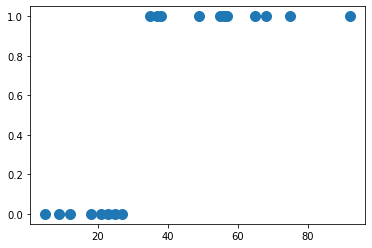

In [382]:
# Data visualization

# from data to vector
#x = test["Age"].to_numpy()
#y = test["Children"].to_numpy()


x = test["Age"].array
y = test["Children"].array



plt.scatter(x, y)

In [383]:
k = 1   #number of predictors, remember theta_0 is for the bias since x_o is always 1

sh=np.shape(x)
m=sh[0] #number of observations in the training data

#x=np.reshape(x, (m,1)) #predictors
x = x.reshape(-1, 1) 

#y=np.reshape(y, (m,1)) #labels
y = y.reshape(-1, 1) 

ones = np.ones ((m,1)) #for the bias x_0

X = np.concatenate((ones,x),axis=1) #matrix of training data

theta = np.random.rand(k+1,1)

#print(theta)
#print(X)

In [384]:
# logistic training

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_train(theta,X,y):   
    epsilon=1.0E-03
    alpha=0.1
    diff=epsilon+1
    theta_old=theta
    c=0
    while diff > epsilon:
        theta_old=theta
        error=sigmoid(np.dot(X,theta))-y
        theta = theta_old - (alpha/m)*np.dot(np.transpose(X),error)
        diff = np.linalg.norm(theta_old-theta)
        c=c+1
        if c == 10000:
            return theta
    return theta

theta=logistic_train(theta,X,y)    


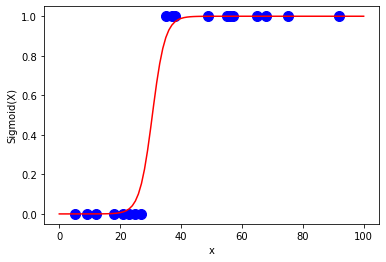

In [385]:
#trained model visualization
x_graph = np.linspace(0, 100, 101)
x_graph=np.reshape(x_graph, (101,1)) #predictors
ones = np.ones ((101,1)) #for the bias x_0
X_graph = np.concatenate((ones,x_graph),axis=1) #matrix of training data

z_graph = sigmoid(np.dot(X_graph,theta))

plt.plot(x_graph, z_graph, c="red")
plt.xlabel("x")
plt.ylabel("Sigmoid(X)")
x = test["Age"].to_numpy()
y = test["Children"].to_numpy()
plt.scatter(x, y, c="blue")

In [386]:
#PREDICTION

threshold = 0.5 #limit where sth is clasify as 1 and not anymore as 0

y_predict = sigmoid(np.dot(X,theta))

y_p = np.zeros(m)

for i in range(1,m):
    if y_predict[i]>threshold:
        y_p[i]=1
        
print(y)
print(y_p)
        
#y labelling
#y_predict return from the sigmoid
#y_p prediction based on a fixed threshold


[0 0 1 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 0]
[0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.]


In [387]:
#EVALUATING THE MODEL

#F-MEASURE
print("F-measure:" , metrics.f1_score(y,y_p))
#the closer to 1, the better the performance is

#K-STATISTIC
print("Kappa:",metrics.cohen_kappa_score(y, y_p))
#the closer to 1, the better the performance is

#AREA UNDER CURVE (AUC), FROM RECEIVING OPERATION CHARACTERISTIC (ROC)
print("AUC:",metrics.roc_auc_score(y,y_p))
# if AUC>0.5 it means the classificator is better than a random process. Perfect classificator <=> AUC=1

#other metrics
print(metrics.classification_report(y,y_p))

F-measure: 1.0
Kappa: 1.0
AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00        11

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



## 1. ACTUAL DATA IMPORT AND PREPROCESS (Both)
Understand dataset and business problem from Cowden et al. (2019).

In [417]:
# Read data from LOSS.mat
mat_loss = loadmat(data_folder + r'\LOSS.mat')
loss_matrix = mat_loss['LOSS']
loss_matrix = np.matrix(loss_matrix)
#select only the first  rows
#loss_matrix = loss_matrix[0:900,:] #in case we dont wanna use the whole set
# Convert into a Pandas Data Frame
loss = pd.DataFrame(loss_matrix, columns=['NOI', 'DSCR', 'LTV', 'Balance', 
                                        'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                                        'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                                        'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR'])

# Read data from PAY.mat
mat_pay = loadmat(data_folder + r'\PAY.mat')
pay_matrix = mat_pay['PAY']
pay_matrix = np.matrix(pay_matrix)
#select only the first rows
#pay_matrix = pay_matrix[0:1900,:] #in case we dont wanna use the whole set
# Convert into a Pandas Data Frame
pay = pd.DataFrame(pay_matrix, columns=['NOI', 'DSCR', 'LTV', 'Balance', 
                                        'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                                        'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                                        'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR'])


# Adding a column to the DataFrames
# the value of the column represents whether the mortgage has been paid back or defaulted
loss['is_paid'] = 0
pay['is_paid'] = 1

# Concatenate pay and loss data into one DataFrame
data_frames = [pay, loss]
pay_loss_not_stand = pd.concat(data_frames)


#What follows is the first way i founded to standarize the data
#it is MANDATORY to do it all together with loss and pay
#doing so, the is_paid column standarizes to -1,1, the code below just turn -1 to 0
#i'd rather use 0 instead of -1 since the code is already desing for that label
#probably there is more efficient way to code it

scaler = StandardScaler()
pay_loss_standarized = scaler.fit_transform(pay_loss_not_stand) 


pay_loss_STAND = pd.DataFrame(pay_loss_standarized, columns=['NOI', 'DSCR', 'LTV', 'Balance', 
                                        'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                                        'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                                        'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR','is_paid'])

#select the rows according to the standarized labels 
#(remember that the labels now follow a normal distribution centered around 0)
PAY_CORRECT=pay_loss_STAND['is_paid']>0
LOSS_CORRECT=pay_loss_STAND['is_paid']<0

filtered_PAY = pay_loss_STAND[PAY_CORRECT]
filtered_LOSS = pay_loss_STAND[LOSS_CORRECT]

#relabelling
filtered_PAY['is_paid']=1
filtered_LOSS['is_paid']=0

data_frames = [filtered_PAY, filtered_LOSS]
pay_loss = pd.concat(data_frames) #concatenated and filtered


# Adding a column to the DataFrames for the independent bias x_o in the literature
pay_loss['BIAS']=1

print(pay_loss.shape) 
#17 predictors, 1 bias, 1 label
#4793 observations: 969 LOSS, 3824 PAY


(4793, 19)


C:\Users\ainol\AppData\Local\Temp/ipykernel_2344/1819276156.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_PAY['is_paid']=1
C:\Users\ainol\AppData\Local\Temp/ipykernel_2344/1819276156.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_LOSS['is_paid']=0


In [418]:
# Split data into training and validation sets
# Training data 70 %, validation data 30 %
train_data, validation_data = model_selection.train_test_split(pay_loss, test_size=0.3) #automatically shuffle

#NOTE: the shuffle is not considering the imbalanced data, maybe:
    #1. reuse the 0 to balance the data
    #2. divide the data taking into account the imbalance. e.g. 30% total = 30%pay + 30%loss. 
    #this idea would be also interesting to implement in the k-fold

#intially implemented without taking care of this -> LET'S SEE WHAT HAPPENS
    
#within the training data, k-fold cross validation will be implemented to select the best parameters
#validation set is only used to assess the model, no to select parameters

In [419]:
#Input vector and labelling

train_x = train_data[['BIAS','NOI', 'DSCR', 'LTV', 'Balance', 
                    'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                    'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                    'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR']].to_numpy() #already proper shape
train_y = train_data['is_paid'].to_numpy()
train_y = train_y.reshape(-1, 1)    

valid_x = validation_data[['BIAS','NOI', 'DSCR', 'LTV', 'Balance', 
                    'Rate', 'Fee','Net_Mortgage_Rate', 'Year_Built', 
                    'Renovation','Occupancy', 'ZipPop', 'CR', 'CS', 
                    'CS_Ratio','NOI_Ratio', 'PV_Ratio', 'IR']].to_numpy() #already proper shape
valid_y = validation_data['is_paid'].to_numpy()
valid_y = valid_y.reshape(-1, 1)    


## 2. BIVARIATE RELATIONSHIPS BETWEEN VARIABLES (Aino)
We examined the bivariate relationships between 

Text(0, 0.5, 'NOI Ratio')

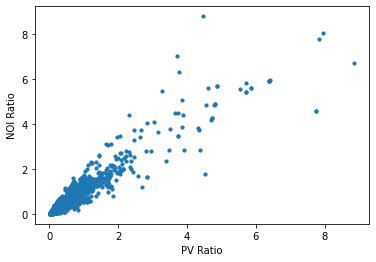

In [420]:
#plt.scatter(pay_loss.Year_Built, pay_loss.IR)
#plt.scatter(pay_loss.ZipPop, pay_loss.CS)
plt.scatter(pay_loss_not_stand.PV_Ratio, pay_loss_not_stand.NOI_Ratio, s=10)
plt.xlabel('PV Ratio')
plt.ylabel('NOI Ratio')

Text(0, 0.5, 'CR')

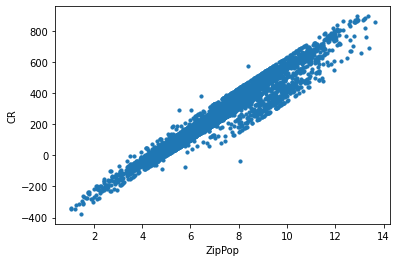

In [393]:
plt.scatter(pay_loss_not_stand.ZipPop, pay_loss_not_stand.CR, s=10)
plt.xlabel('ZipPop')
plt.ylabel('CR')

Text(0, 0.5, 'Balance (million $)')

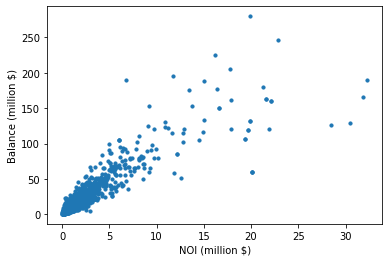

In [403]:
plt.scatter(pay_loss_not_stand.NOI / 10 ** 6 , pay_loss_not_stand.Balance / 10 ** 6, s=10)
plt.xlabel('NOI (million $)')
plt.ylabel('Balance (million $)')
# plt.scatter(pay_loss.NOI, pay_loss.NOI_Ratio) <--- obviously correlated
# plt.scatter(pay_loss.Balance, pay_loss.NOI_Ratio) <--- also obviously correlated

Text(0, 0.5, 'PV Ratio')

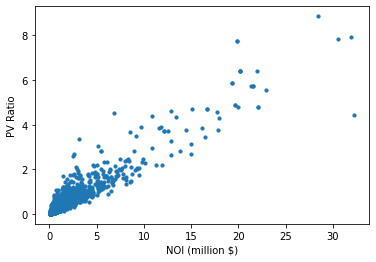

In [404]:
plt.scatter(pay_loss_not_stand.NOI / 10 ** 6 , pay_loss_not_stand.PV_Ratio, s=10)
plt.xlabel('NOI (million $)')
plt.ylabel('PV Ratio')
# --> plt.scatter(pay_loss.Balance, pay_loss.PV_Ratio)  
# and plt.scatter(pay_loss.PV_Ratio, pay_loss.NOI_Ratio) also correlated

Text(0, 0.5, 'Net Mortgage Rate (%)')

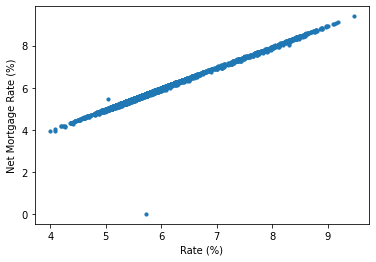

In [405]:
plt.scatter(pay_loss_not_stand.Rate, pay_loss_not_stand.Net_Mortgage_Rate, s=10)
plt.xlabel('Rate (%)')
plt.ylabel('Net Mortgage Rate (%)')

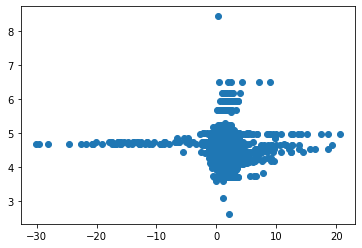

In [83]:
# For whatever reason, these do (still) not appear linearly correlated (!!?)
# REMOVE FROM THE ACTUAL PROJECT
plt.scatter(pay_loss_not_stand.CS, pay_loss_not_stand.CS_Ratio)

## 3. SELECTION OF THE MOST RELEVANT VARIABLES (Aino + revision by Raúl)

This information may be relevant
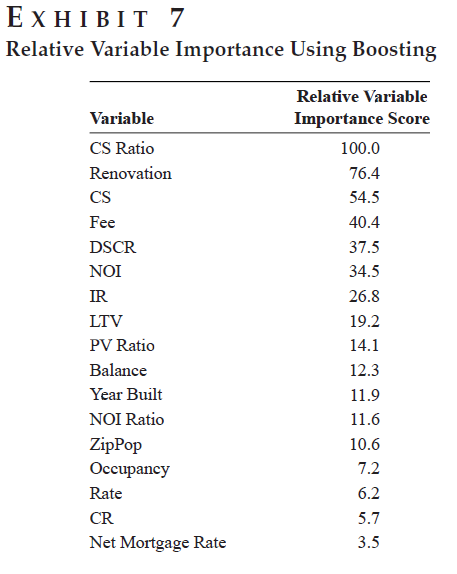 

## Forward and Backward Stepwise Regression

These need some adjusting, and I haven't quite figured out yet why my custom-made function selects different columns in
backward selection than SequentialFeatureSelection. (Related to the use of random forest classifier with SequentialFeatureSelection?)

In [494]:
# Forward stepwise selection
svm = SVC()

forward_feature_selection = sfs(svm,
                                forward=True,
                                floating=False,
                                verbose=2,
                                scoring='roc_auc',
                                k_features=1,
                                cv=5)

x = train_x
np.delete(x, 0) # train_x includes a column for bias at index 0. Do not use this column for feature selection.
forward_feature_selection = forward_feature_selection.fit(x, train_data['is_paid'].to_numpy()) # train_y as a 1d vector

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   23.1s finished

[2022-03-01 20:54:15] Features: 1/1 -- score: 0.5579012456681556

In [428]:
# Backward stepwise Regression
svm = SVC()

backward_feature_selection = sfs(svm,
                                forward=False,
                                floating=False,
                                verbose=2,
                                scoring='roc_auc',
                                k_features=17,
                                cv=5)

x = train_x
np.delete(x, 0) # train_x includes a column for bias at index 0. Do not use this column for feature selection.
backward_feature_selection = backward_feature_selection.fit(x, train_data['is_paid'].to_numpy()) # train_y as a 1d vector

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.1min finished

[2022-02-27 21:56:04] Features: 17/1 -- score: 0.6041792584053198[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  17 out of  17 | elapsed:   53.8s finished

[2022-02-27 21:56:58] Features: 16/1 -- score: 0.6078431916373251[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:   50.6s finished

[2022-02-27 21:57:48] Features: 15/1 -- score: 0.6108865804439702[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

## Best Subset Selection

In [376]:
# Best subset selection for a specific number of predictors k
def get_best(k, X, y):
    results = []

    # For each combination with a specific k value
    for combo in itertools.combinations(X.columns, k):
        svm = SVC()
        model = svm.fit(X[list(combo)], y)
        predY_svm = svm.predict(X[list(combo)])
        # Calculate AUC for the model
        auc = metrics.accuracy_score(y, predY_svm)
        results.append({'model':model, 'AUC':auc})
        print(".", end="") # Please ignore, just wanted to see the progress

    models = pd.DataFrame(results)
    # The best model is the one with the biggest AUC
    best_model = models.loc[models['AUC'].argmax()]

    return best_model

In [377]:
# SHOULD PROBABLY USE SCALED/NORMALIZED VALUES!? (wait what, they are already?)
# Problem with the huge amount of cases 
# (yes, printing the progress costs a lot of extra time, but needed to make sure the function is not stuck)
X = train_data.drop(['BIAS', 'is_paid'], axis=1)
y = train_data.is_paid

# Call the get_best() function for each number of predictors k
best_models = pd.DataFrame(columns = ['model', 'AUC'])
for i in range(1, 18):
    print("\n",i)
    best_models.loc[i] = get_best(i, X, y)


 1
.................
 2
........................................................................................................................................
 3
........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
 4
.......................................................................................................................................................

KeyboardInterrupt: 

## 4. COMPARISON AMONG MODELS

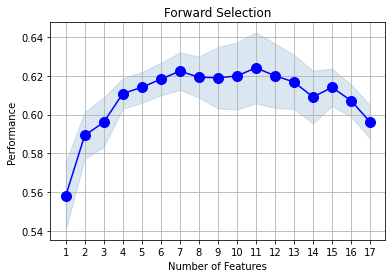

In [422]:
fig = plot_sfs(forward_feature_selection.get_metric_dict(), kind='std_err')
plt.title('Forward Selection')
plt.grid()
plt.show()

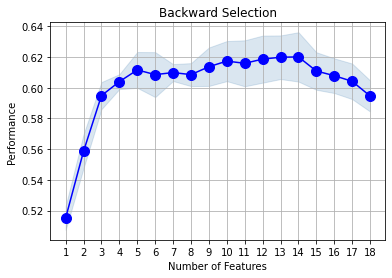

In [425]:
fig = plot_sfs(backward_feature_selection.get_metric_dict(), kind='std_err')
plt.title('Backward Selection')
plt.grid()
plt.show()

## 5. IMPLEMENTATION OF THE LOGISTIC REGRESSION WITH THE ACTUAL DATA. (Raúl)
All predictors (k=17), TODO: keep the unbalancing within the data

In [91]:
#TRAINING WITH K-FOLD CROSS VALIDATION FOR PARAMETER SELECTION

kf = KFold(n_splits=10)

#print(kf)

#print(kf.split(X))

k=17; # DO IT AUTOMATICALLY, related with the number of predictors=number of columns apart from labelling or bias term
threshold = 0.5
AUC=0

for train_index, test_index in kf.split(train_x):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train_folded, X_test = train_x[train_index], train_x[test_index]
    y_train_folded, y_test = train_y[train_index], train_y[test_index]
    #model training and evaluation for every fold
    theta = np.random.rand(k+1,1)
    theta=logistic_train(theta,X_train_folded,y_train_folded)    
    y_p = sigmoid(np.dot(X_test,theta))
    h=y_p.shape[0]
    y_predict = np.zeros(h)
    for i in range(1,h): #this is just to control the threshold, no extrictly needed
        if y_p[i]>threshold:
            y_predict[i]=1         
    AUC_current=metrics.roc_auc_score(y_test,y_predict)
    #print("AUC:",metrics.roc_auc_score(y_test,y_predict))
    if AUC_current>AUC: #just selecting the best out of the total folds 
        AUC=AUC_current
        theta_out=theta
        
#print(theta_out) #parameters of the model
print("The model offers a AUC of:",AUC)
    

The model offers a AUC of: 0.622396819386596


## 6. SUPPORT VECTOR MACHINE + TUNING ITS PARAMETERS (Aino, before the 02.03 ev)

I think the only parameter that can be tunned is the kernel being used

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [454]:
trainY = train_data['is_paid'].to_numpy()
svm = SVC()
svm.fit(train_x, trainY)    # trainY != train_y, different shape
predY_svm = svm.predict(valid_x)

F1 score: 0.9021571648690292


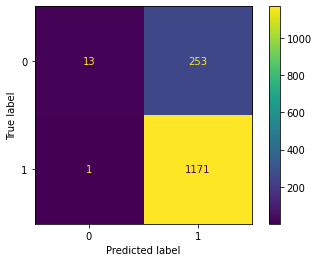

In [459]:
validY = validation_data['is_paid'].to_numpy()
cm = metrics.confusion_matrix(valid_y, predY_svm)
f1 = metrics.f1_score(valid_y, predY_svm)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print("F1 score:", f1)

F1 score: 0.8995363214837714


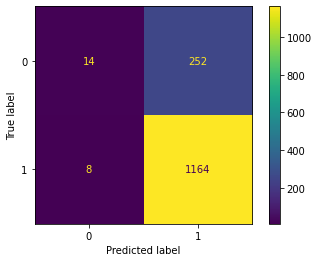

In [490]:
trainY = train_data['is_paid'].to_numpy()
svm = SVC(kernel='poly', coef0=20)
svm.fit(train_x, trainY)    # trainY != train_y, different shape
predY_svm = svm.predict(valid_x)

validY = validation_data['is_paid'].to_numpy()
cm = metrics.confusion_matrix(valid_y, predY_svm)
f1 = metrics.f1_score(valid_y, predY_svm)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
print("F1 score:", f1)

## 7. NEURAL NETWORK + TUNING ITS PARAMETERS (Raúl, before the 02.03 evening)

Parameters subject of study, layers and neurons per layer

https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier

## 8. AMONG TECHNIQUES COMPARISION (Together on the 02.03 evening)

In [ ]:
Table including the AUC offered by each classificator



## 9. GENERAL CONCLUSION (Together on the 02.03 evening)